In [37]:
import pandas
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, precision_score, make_scorer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import export_graphviz
from six import StringIO
from IPython.display import Image  
import pydotplus
from pydotplus import graph_from_dot_data
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
import numpy
from sklearn.svm import LinearSVC, SVC

# Úkol-04

### Data

In [3]:
data = pandas.read_csv("ukol_04_data.csv")
data.head(20)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no
5,35,management,married,tertiary,no,231,yes,no,unknown,5,may,139,1,-1,0,unknown,no
6,28,management,single,tertiary,no,447,yes,yes,unknown,5,may,217,1,-1,0,unknown,no
7,42,entrepreneur,divorced,tertiary,yes,2,yes,no,unknown,5,may,380,1,-1,0,unknown,no
8,58,retired,married,primary,no,121,yes,no,unknown,5,may,50,1,-1,0,unknown,no
9,43,technician,single,secondary,no,593,yes,no,unknown,5,may,55,1,-1,0,unknown,no


### Rozhodovací strom

Vytvoř rozhodovací strom na základě všech vstupních proměnných, s výjimkou proměnných day a month. Výstupní proměnnou je informace, zda si klient založní termínovaný účet. Omez výšku stromu na 4 patra a vygeneruj obrázek (v rámci Jupyter notebooku nebo jej ulož jako samostatný obrázek). Kategoriální proměnné uprav pomocí OneHotEncoder, číselné proměnné nijak upravovat nemusíš. Dále vytvoř matici záměn a urči výši metriky accuracy.

In [6]:
#Rozdělení sloupců na kategorické a numerické proměnné
categorical_cols = ["job", "marital", "education", "default", "housing", "loan", "contact", "poutcome"]
numeric_cols = ["balance", "duration", "campaign", "pdays", "previous"]

#OneHotEncoder pro převod kategoriálních proměnných
ohe = OneHotEncoder()
encoded_cols = ohe.fit_transform(data[categorical_cols])
#Převod na pole (array)
encoded_cols = encoded_cols.toarray()
encoded_cols

array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 1., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 1., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 1., 0., 0.]])

In [17]:
#názvy sloupců kategorických po úpravě OneHotEncoderem (převod na seznam/list)
categorical_cols_names = list(ohe.get_feature_names_out())
categorical_cols_names

['job_admin.',
 'job_blue-collar',
 'job_entrepreneur',
 'job_housemaid',
 'job_management',
 'job_retired',
 'job_self-employed',
 'job_services',
 'job_student',
 'job_technician',
 'job_unemployed',
 'job_unknown',
 'marital_divorced',
 'marital_married',
 'marital_single',
 'education_primary',
 'education_secondary',
 'education_tertiary',
 'education_unknown',
 'default_no',
 'default_yes',
 'housing_no',
 'housing_yes',
 'loan_no',
 'loan_yes',
 'contact_cellular',
 'contact_telephone',
 'contact_unknown',
 'poutcome_failure',
 'poutcome_other',
 'poutcome_success',
 'poutcome_unknown']

In [8]:
#převod numerických proměnných na pole (array)
other_cols = data[numeric_cols].to_numpy()
other_cols

array([[2143,  261,    1,   -1,    0],
       [  29,  151,    1,   -1,    0],
       [   2,   76,    1,   -1,    0],
       ...,
       [ 295,  151,   11,   -1,    0],
       [1137,  129,    4,  211,    3],
       [1136,  345,    2,  249,    7]], dtype=int64)

In [13]:
#propojení kategorických a numerických proměnných do jednoho pole = vstupní proměnná
X = numpy.concatenate([encoded_cols, other_cols], axis=1)
#výstupní proměnná (založení terminovaného účtu: ano/ne)
y = data["y"]
#rozdělení dat na testovací a trénovací sadu
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

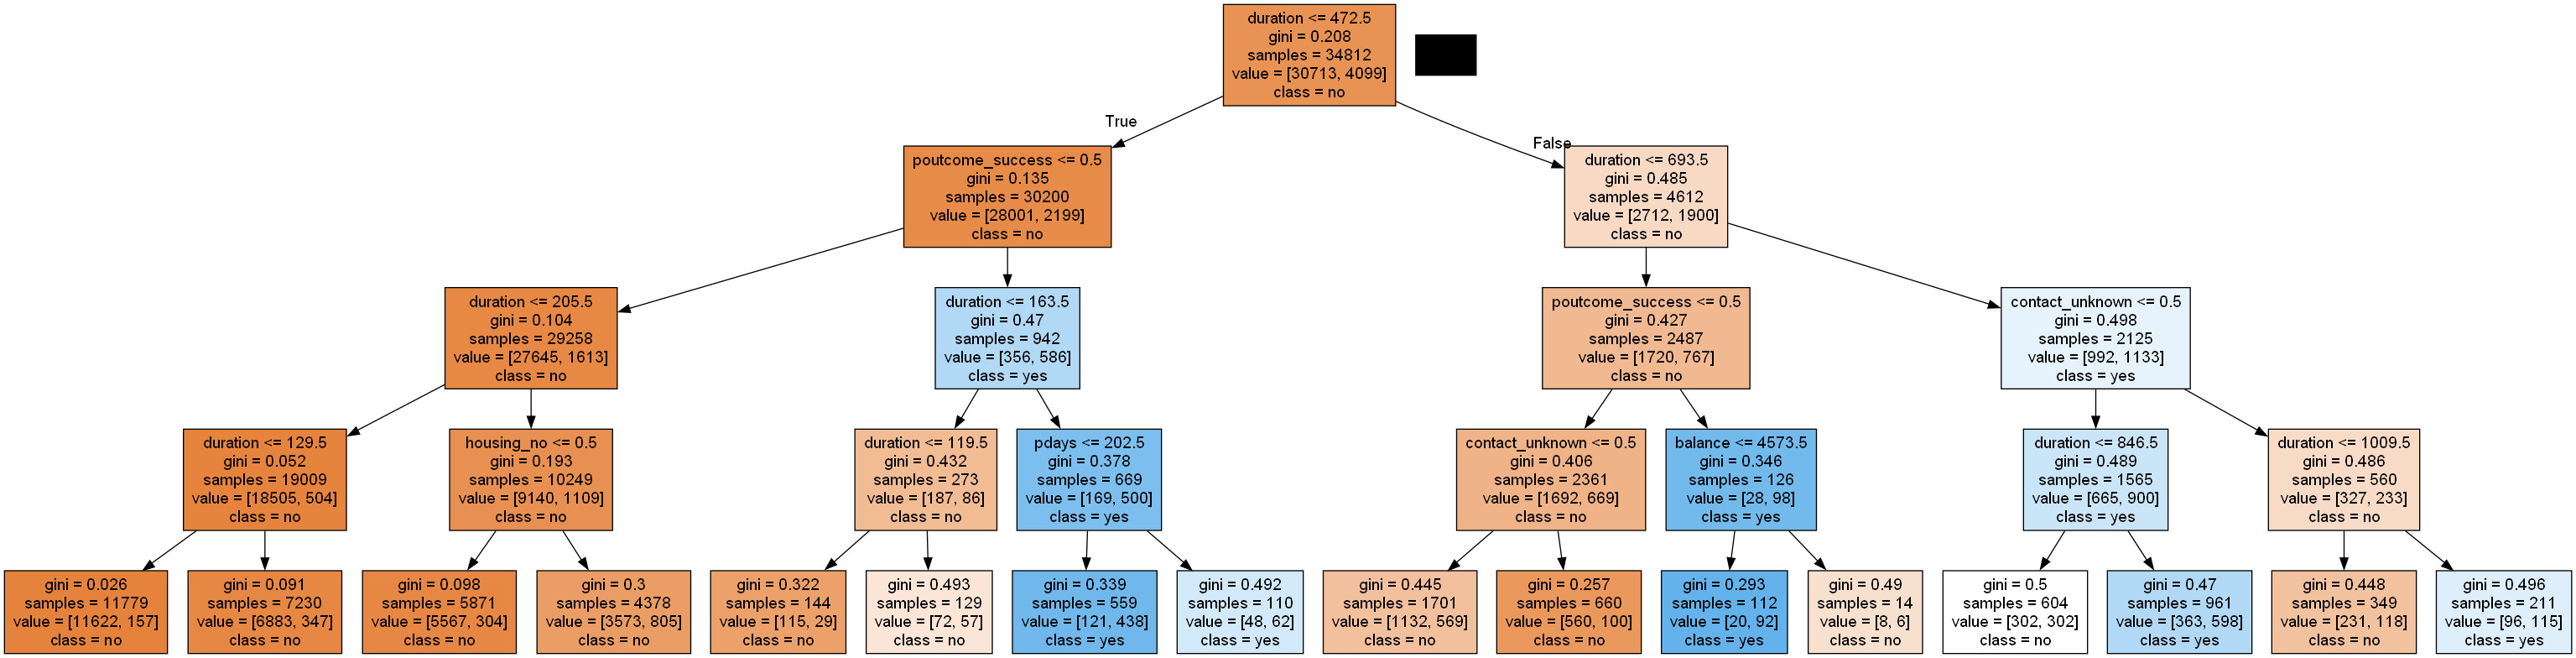

In [18]:
#rozhodovací strom o 4 patrech
clf = DecisionTreeClassifier(max_depth=4)
clf = clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
#zobrazení výsledného stromu
dot_data = StringIO()
export_graphviz(clf, out_file=dot_data, filled=True, feature_names=categorical_cols_names + numeric_cols, class_names=clf.classes_)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())

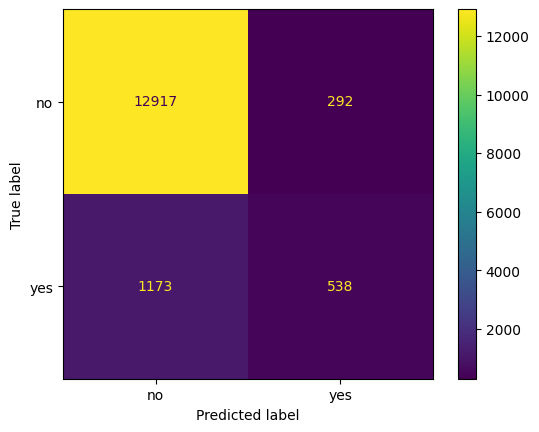

In [19]:
#vytvoření matice záměn
ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test)

In [20]:
#výpočet accuracy skóre
accuracy_score(y_test, y_pred)

0.9018096514745308

### Výběr metriky a nejlepšího algoritmu

Vedení marketingového oddělení banky rozhodlo, že chce využít strojové učení k efektivní kampani. Chce ale vybrat nejlepší algoritmus, který bude predikovat, kdo z klientů má o termínovaný účet zájem. Následně bude kontaktovat ty, u kterých model predikuje zájem, a nebude kontaktovat ty, u kterých model bude predikovat nezájem. Algoritmus bude vybrán na základě jedné z metrik, které jsme si ukazovali na 9. lekci. Vedení marketingového oddělení se chce vyhnout zbytečnému kontaktování klientů, kteří o termínovaný účet nemají zájem. Nevadí, pokud se neozvou někomu, kdo o termínovaný vklad zájem má. Vyber podle této preference vedení vhodnou metriku. Metriku napiš jako komentář v programu nebo jej doplň do buňky v Jupyter notebooku.

Vhodnou metrikou je <code>precision</code> skóre, protože tato metrika penalizuje falešně pozitivní (false positive) výsledky, t. j. zákazníky modelem klasifikované jako "ano, mají zájem", přestože ve skutečnosti zájem nemají. Tato metrika nebere v potaz falešně negativní (false negative) výsledky, t. j. zákazníky, kteří zájem mají, ale byli algoritmem klasifikováni jako "ne, nemají zájem".

Vypočítej hodnotu vybrané metriky pro rozhodovací strom, který byl vytvořen v prvním bodě.

In [21]:
precision_score(y_test, y_pred, pos_label="yes")

0.6481927710843374

### K Nearest Neighbours

Využij algoritmus K Nearest Neighbours k predikci, zda si klient/klientka založí termínovaný účet. Využij všechny vstupní proměnné, s výjimkou proměnných day a month. Kategoriální proměnné uprav pomocí OneHotEncoder (tj. stejně jako u rozhodovacího stromu). Na číselné proměnné tentokrát použij StandardScaler. Pomocí cyklu (nebo pomocí GridSearchCV) urči počet uvažovaných sousedů, které algoritmus bere v úvahu. Uvažuj následující hodnoty parametru: 3, 7, 11, 15, 19, 23. Jaká je nejlepší hodnota metriky? A je lepší než u rozhodovacího stromu?

In [22]:
#kategoriální proměnné už jsou upravené v proměnné encoded_cols
#použití StandardScaler na numerické proměnné
scaler = StandardScaler()
numeric_cols_scaled = scaler.fit_transform(data[numeric_cols])
numeric_cols_scaled

array([[ 0.25488033,  0.00896181, -0.57003031, -0.41106788, -0.25584899],
       [-0.44015359, -0.41782396, -0.57003031, -0.41106788, -0.25584899],
       [-0.44903056, -0.70881425, -0.57003031, -0.41106788, -0.25584899],
       ...,
       [-0.35269899, -0.41782396,  2.6567718 , -0.41106788, -0.25584899],
       [-0.07586902, -0.50318111,  0.39801033,  1.70626182,  1.07463712],
       [-0.0761978 ,  0.33487093, -0.2473501 ,  2.08578318,  2.8486186 ]])

In [24]:
#propojení kategorických a numerických proměnných do jednoho pole = vstupní proměnná
X2 = numpy.concatenate([encoded_cols, numeric_cols_scaled], axis=1)
#výstupní proměnná zůstává stejná
#rozdělení dat na trénovací a testovací
X_train, X_test, y_train, y_test = train_test_split(X2, y, test_size=0.3, random_state=42)

In [34]:
#použití algoritmu KNN
clf_knn = KNeighborsClassifier()
#porovnávané parametry
params = {"n_neighbors": [3, 7, 11, 15, 19, 23]}
#vytvoření metriky precision_score (scoring="precision" mi nefungovalo - na stackoverflow jsem našla toto řešení)
custom_scorer = make_scorer(precision_score, greater_is_better=True, pos_label="yes")
#použití GridSearchCV k vybrání nejlepšího parametru
clf_grid = GridSearchCV(clf_knn, params, scoring=custom_scorer)
clf_grid.fit(X2, y)
#nejlepší parametr
clf_grid.best_params_

{'n_neighbors': 23}

In [35]:
clf_grid.best_score_

0.5661424343200696

Nejlepší hodnota metriky precision skóre u algoritmu K Nearest Neighbours je 0.5661424343200696. Je to méně než u rozhodovacího stromu, který má precision skóre 0.6481927710843374. Rozhodovací strom je tedy asi o 8 p. b. přesnější.

### Support Vector Machine - Linear

Jako druhý využij algoritmus Support Vector Machine. Využij lineární verzi, tj. LinearSVC. Algoritmus využij s výchozími hodnotami parametrů, tj. nemusíš zkoušet různé hodnoty parametrů. Vypočti hodnotu požadované metriky.

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X2, y, test_size=0.3, random_state=42)
clf_svc = LinearSVC()
clf_svc.fit(X_train, y_train)
y_pred = clf_svc.predict(X_test)
precision_score(y_test, y_pred, pos_label = "yes")

c:\Users\klama\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


0.6557591623036649

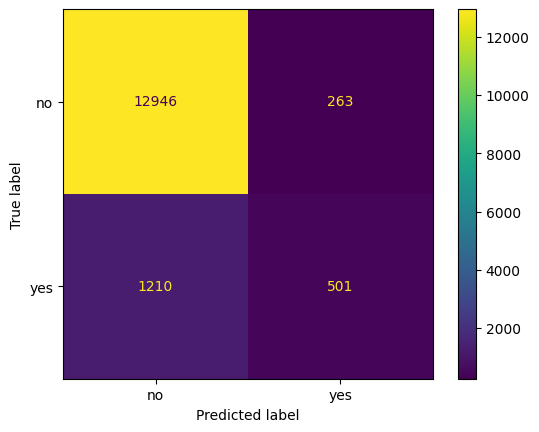

In [46]:
ConfusionMatrixDisplay.from_estimator(clf_svc, X_test, y_test)

Porovnej hodnoty metrik pro rozhodovací strom, K Nearest Neighbours a Support Vector Machine. Ve kterém z bodů jsme dosáhli nejvyšší hodnoty metriky?

Nejvyšší hodnota metriky je pomocí Support Vector Machine (65,58% přesnost), o něco méně přesný je rozhodovací strom (64,82% přesnost). Nejméně přesný byl algoritmus K Nearest Neighbours (56,6% přesnost).

### Bonus

Pomocí cyklu vyzkoušej další možné výšky rozhodovacího stromu, například v rozmezí 5 až 12.

In [51]:
#rozdělení dat
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
#slovník k uložení výsledků
values = {}
#cyklus
for i in range(5, 13):
    clf = DecisionTreeClassifier(max_depth=i)
    clf = clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    precision = precision_score(y_test, y_pred, pos_label="yes")
    values[i] = precision

values


{5: 0.6180124223602484,
 6: 0.6113989637305699,
 7: 0.6131805157593123,
 8: 0.6223132036847492,
 9: 0.5841242450388265,
 10: 0.5884995507637018,
 11: 0.5704,
 12: 0.5586816720257235}

Žádné z těchto skóre není vyšší než skóre pro 4 patrový strom. Nejlepší skóre má stále algoritmus Support Vector Machine.

Pozn.: Nemůžu přijít na to, proč mi metrika u LinearSVC vychází jinak než 84 % uvedených v nápovědě.